In [36]:
!pip install xlsxwriter
!pip install pyLDAvis
!pip install pandas
!pip install pandas==1.3.1

In [37]:

import xlsxwriter
import xlrd
import openpyxl
from openpyxl import load_workbook
import os
import os.path
from os import path
import datetime as dt
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import csv
import sqlite3 as sql
import pandas as pd
pd.options.mode.chained_assignment = None
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
display_images = True

In [39]:
os.chdir("drive/My Drive")

FileNotFoundError: ignored

data preprocessing

In [40]:
cnx_2018 = sql.connect('USML_Project/Data/2018_articles.db')

In [41]:
df = pd.read_sql_query("SELECT * FROM articles WHERE (source LIKE '%CNN%') OR (source LIKE '%Fox News%') OR (source LIKE '%NBC%') ", cnx_2018)
df.head()

,date,source,name,content
0,2018-02-05,CNBC,A 150 tweet by Speaker Ryan raised his challen...,One inexpensive and quickly deleted tweet by...
1,2018-02-05,CNBC,After Dow plunges White House says its focused...,The White House said Monday it is worried abou...
2,2018-02-05,CNBC,Devin Nunes Trump never met with Papadopoulos ...,Rep. Devin Nunes is the author of a newly decl...
3,2018-02-05,CNBC,He must be stopped Trump lashes out at top Dem...,President Donald Trump lashed out at the top D...
4,2018-02-05,CNBC,House Intelligence panel votes to release Demo...,The House Intelligence Committee voted Monday ...


In [ ]:
nbc_2018 = pd.read_sql_query("SELECT * FROM articles WHERE source LIKE '%NBC%'", cnx_2018)


fox_2018 = pd.read_sql_query("SELECT * FROM articles WHERE source LIKE '%Fox News%'", cnx_2018)


cnn_2018 = pd.read_sql_query("SELECT * FROM articles WHERE source LIKE '%CNN%'", cnx_2018)

In [ ]:
import re
#this is only for the content column. propbs should do titles too
#df = df.sample(n=10000, random_state=1)
nbc_2018['content_processed'] = \
nbc_2018['content'].map(lambda x: re.sub('[,\.!?]', '', x))

nbc_2018['content_processed'] = \
nbc_2018['content_processed'].map(lambda x: x.lower())

nbc_2018['content_processed'].head()


0    one inexpensive  and quickly deleted  tweet by...
1    the white house said monday it is worried abou...
2    rep devin nunes is the author of a newly decla...
3    president donald trump lashed out at the top d...
4    the house intelligence committee voted monday ...
Name: content_processed, dtype: object

In [ ]:
from collections import Counter
  

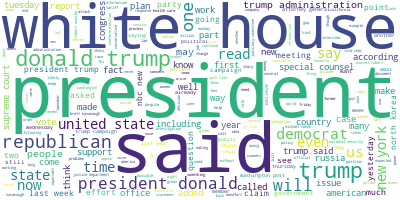

In [ ]:
from wordcloud import WordCloud
#samp = df.sample(n=5000, random_state=1)#running without sample was so big it crashed colab
long_string = ','.join(list(nbc_2018['content_processed'].values))

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [ ]:
import re
#this is only for the content column. propbs should do titles too
#df = df.sample(n=10000, random_state=1)
fox_2018['content_processed'] = \
fox_2018['content'].map(lambda x: re.sub('[,\.!?]', '', x))

fox_2018['content_processed'] = \
fox_2018['content_processed'].map(lambda x: x.lower())

fox_2018['content_processed'].head()


0    president trump announced late last year that ...
1    **want fox news halftime report in your inbox ...
2    after years of democratic rule and high taxes ...
3    rudy giuliani president trumps personal lawyer...
4    the country is still digesting justice departm...
Name: content_processed, dtype: object

In [ ]:
import re
#this is only for the content column. propbs should do titles too
#df = df.sample(n=10000, random_state=1)
cnn_2018['content_processed'] = \
cnn_2018['content'].map(lambda x: re.sub('[,\.!?]', '', x))

cnn_2018['content_processed'] = \
cnn_2018['content_processed'].map(lambda x: x.lower())

cnn_2018['content_processed'].head()


0    (cnn) president donald trump on monday boasted...
1    (cnn) there was president donald trump on mond...
2    former vice president joe biden said tuesday t...
3    abc's "good morning america" anchor george ste...
4    washington (cnn) white house chief of staff jo...
Name: content_processed, dtype: object

In [42]:
import re
#this is only for the content column. propbs should do titles too
#df = df.sample(n=10000, random_state=1)
df['content_processed'] = \
df['content'].map(lambda x: re.sub('[,\.!?]', '', x))

df['content_processed'] = \
df['content_processed'].map(lambda x: x.lower())

df['content_processed'].head()


0    one inexpensive  and quickly deleted  tweet by...
1    the white house said monday it is worried abou...
2    rep devin nunes is the author of a newly decla...
3    president donald trump lashed out at the top d...
4    the house intelligence committee voted monday ...
Name: content_processed, dtype: object

In [43]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'https', 'said', 'us', 'would', 'like','says', 'could', 'two', 'told', 'going', 'one', 'trump'])

In [46]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [47]:
#
#do a all three artiles dataset version of LDA SLI
#df
data = df.content_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])




['inexpensive', 'quickly', 'deleted', 'tweet', 'house', 'speaker', 'paul', 'ryan', 'raising', 'whole', 'bunch', 'donations', 'democratic', 'challenger', 'ryan', 'wisc', 'hit', 'quick', 'twitter', 'backlash', 'saturday', 'highlighting', 'news', 'story', 'public', 'school', 'secretary', 'taking', 'home', 'whopping']


In [48]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 2), (6, 1), (7, 3), (8, 1), (9, 5), (10, 1), (11, 2), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 5), (29, 1)]


Change data frame in next section to see results for different sources

Did not redo the code for each different data frame

In [49]:
#do a all three artiles dataset version of LDA SLI
#Change df to any of the other datasets to see source specific results. 
data = df.content_processed.values.tolist()#change df to nbc_2018/cnn_2018/fox_2018
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])



['inexpensive', 'quickly', 'deleted', 'tweet', 'house', 'speaker', 'paul', 'ryan', 'raising', 'whole', 'bunch', 'donations', 'democratic', 'challenger', 'ryan', 'wisc', 'hit', 'quick', 'twitter', 'backlash', 'saturday', 'highlighting', 'news', 'story', 'public', 'school', 'secretary', 'taking', 'home', 'whopping']


In [50]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 2), (6, 1), (7, 3), (8, 1), (9, 5), (10, 1), (11, 2), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 5), (29, 1)]


In [51]:
from pprint import pprint
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics

t = lda_model.print_topics()
#pprint(lda_model.print_topics())
for i in range(len(t)):
  var = str(t[i][0])
  var2 = str(t[i][1])
  print("topic: " + var )
  print( var2)



doc_lda = lda_model[corpus]

topic: 0
0.009*"president" + 0.006*"house" + 0.006*"new" + 0.004*"also" + 0.004*"people" + 0.004*"democrats" + 0.004*"administration" + 0.003*"department" + 0.003*"campaign" + 0.003*"white"
topic: 1
0.007*"election" + 0.007*"president" + 0.006*"state" + 0.006*"republican" + 0.005*"campaign" + 0.005*"democrats" + 0.005*"house" + 0.005*"senate" + 0.004*"also" + 0.004*"voters"
topic: 2
0.010*"president" + 0.005*"saudi" + 0.004*"administration" + 0.004*"also" + 0.003*"house" + 0.003*"white" + 0.003*"officials" + 0.003*"people" + 0.003*"khashoggi" + 0.003*"united"
topic: 3
0.012*"president" + 0.009*"mueller" + 0.007*"investigation" + 0.006*"house" + 0.006*"cohen" + 0.005*"manafort" + 0.005*"counsel" + 0.005*"attorney" + 0.005*"russia" + 0.005*"campaign"
topic: 4
0.007*"democrats" + 0.006*"house" + 0.006*"senate" + 0.006*"democratic" + 0.006*"kavanaugh" + 0.006*"president" + 0.005*"vote" + 0.005*"republican" + 0.005*"state" + 0.004*"republicans"


In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(12)






,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.8342,"democrats, republican, democratic, state, hous...","[inexpensive, quickly, deleted, tweet, house, ..."
1,1,2.0,0.9777,"democrats, republican, democratic, state, hous...","[white, house, monday, worried, stock, market,..."
2,2,4.0,0.5160,"committee, kavanaugh, president, house, invest...","[rep, devin, nunes, author, newly, declassifie..."
3,3,4.0,0.9891,"committee, kavanaugh, president, house, invest...","[president, donald, lashed, top, democrat, hou..."
4,4,4.0,0.9904,"committee, kavanaugh, president, house, invest...","[house, intelligence, committee, voted, monday..."
5,5,2.0,0.9974,"democrats, republican, democratic, state, hous...","[president, donald, monday, offered, country, ..."
6,6,2.0,0.8655,"democrats, republican, democratic, state, hous...","[day, markets, already, putting, fed, chair, j..."
7,7,2.0,0.7319,"democrats, republican, democratic, state, hous...","[jerome, powell, hands, full, become, chairman..."
8,8,0.0,0.9525,"president, kavanaugh, senate, vote, house, cou...","[senators, introducing, compromise, legislatio..."
9,9,2.0,0.5356,"democrats, republican, democratic, state, hous...","[leading, republican, campaign, group, offerin..."


In [ ]:


# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant Topic', 'Topic Words', 'Number of Documents', '% of Documents']

# Show
df_dominant_topics

# Show
df_dominant_topics.head(12)

,Dominant Topic,Topic Words,Number of Documents,% of Documents
0.0,1.0,"house, president, new, senate, republican, rea...",1774.0,0.1965
1.0,2.0,"kavanaugh, president, read, court, state, repu...",1782.0,0.1973
2.0,3.0,"president, mueller, campaign, russia, read, el...",1618.0,0.1792
3.0,1.0,"house, president, new, senate, republican, rea...",2244.0,0.2485
4.0,1.0,"house, president, new, senate, republican, rea...",1612.0,0.1785
5.0,0.0,"president, house, democrats, senate, republica...",NaN,NaN
6.0,0.0,"president, house, democrats, senate, republica...",NaN,NaN
7.0,0.0,"president, house, democrats, senate, republica...",NaN,NaN
8.0,1.0,"house, president, new, senate, republican, rea...",NaN,NaN
9.0,3.0,"president, mueller, campaign, russia, read, el...",NaN,NaN


In [ ]:
df_dominant_topics.groupby(['Dominant Topic', 'Topic Words']).sum()

,,Number of Documents,% of Documents
Dominant Topic,Topic Words,,
0.0,"president, house, democrats, senate, republican, donald, also, white, new, campaign",0.0,0.0000
1.0,"house, president, new, senate, republican, read, time, administration, democrats, white",5630.0,0.6235
2.0,"kavanaugh, president, read, court, state, republican, new, news, election, democratic",1782.0,0.1973
3.0,"president, mueller, campaign, russia, read, election, donald, also, former, new",1618.0,0.1792
4.0,"president, house, new, white, former, donald, election, also, news, read",0.0,0.0000


In [ ]:
len(df.index)

20338

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.089633  0.021433       1        1  30.442213
1      0.081652 -0.023844       2        1  23.916180
0     -0.028078 -0.086729       3        1  21.825724
4      0.023483  0.028581       4        1  15.471878
2      0.012576  0.060560       5        1   8.344005, topic_info=            Term          Freq         Total Category  logprob  loglift
187        trump  78392.000000  78392.000000  Default  30.0000  30.0000
21306  kavanaugh  11984.000000  11984.000000  Default  29.0000  29.0000
10577   manafort   5255.000000   5255.000000  Default  28.0000  28.0000
2706       court  12223.000000  12223.000000  Default  27.0000  27.0000
244      mueller  11051.000000  11051.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
66          news    997.939130  11984.749654   Topic5  -5.9864  -0.0021
482       senate   1002.909882  15464.222695   Topic5  -5.9815  -0.2520
429          new    976.439678  16338.073380   Topic5  -6.0082  -0.3337
371       former    949.590516  12188.694146   Topic5  -6.0361  -0.0686
691         time    927.965946  11311.941722   Topic5  -6.0591  -0.0170

[489 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
24646      2  0.939941    aborted
24646      4  0.025404    aborted
197        1  0.280934  according
197        2  0.215769  according
197        3  0.241835  according
...      ...       ...        ...
15771      5  0.724982     zinkes
11353      2  0.028922      zwaan
11353      3  0.028922      zwaan
11353      4  0.057845      zwaan
11353      5  0.896590      zwaan

[1514 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 5, 3])

In [52]:
#try doing same with LSI
#this is for LSI model
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


lsimodel = LsiModel(corpus, num_topics=5, id2word =id2word)

t = lsimodel.print_topics()
#pprint(lda_model.print_topics())
for i in range(len(t)):
  var = str(t[i][0])
  var2 = str(t[i][1])
  print("topic: " + var )
  print( var2)

topic: 0
0.328*"president" + 0.243*"house" + 0.158*"white" + 0.142*"republican" + 0.138*"democrats" + 0.138*"also" + 0.126*"new" + 0.122*"campaign" + 0.117*"senate" + 0.114*"state"
topic: 1
-0.291*"president" + 0.265*"democrats" + 0.233*"republican" + 0.209*"kavanaugh" + 0.199*"democratic" + 0.192*"senate" + 0.174*"republicans" + -0.157*"white" + 0.151*"voters" + 0.150*"vote"
topic: 2
0.621*"kavanaugh" + 0.259*"court" + 0.232*"ford" + 0.164*"committee" + 0.150*"fbi" + 0.140*"supreme" + 0.131*"judge" + -0.128*"state" + 0.120*"investigation" + 0.107*"hearing"
topic: 3
0.295*"house" + 0.291*"white" + -0.249*"campaign" + -0.243*"manafort" + -0.210*"mueller" + 0.197*"kavanaugh" + 0.181*"north" + -0.181*"investigation" + -0.151*"fbi" + 0.142*"korea"
topic: 4
-0.475*"house" + -0.333*"white" + 0.298*"north" + 0.223*"korea" + 0.180*"kim" + -0.143*"fbi" + 0.133*"court" + 0.122*"nuclear" + 0.119*"state" + -0.114*"comey"


coherence section

In [53]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=4, limit=30, step=5)

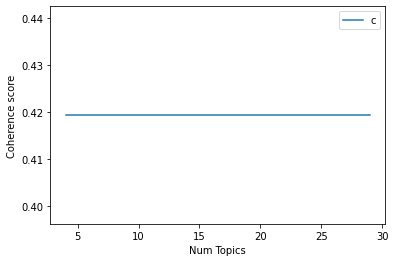

In [ ]:
# Show graph
limit=30; start=4; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
#no effect on coherence at all?????????

In [54]:
print('\nPerplexity:', lda_model.log_perplexity(corpus))

from gensim.models import CoherenceModel

coherence_score_lda = CoherenceModel(lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nCoherence Score:', coherence_score)


Perplexity: -8.421973268205186

Coherence Score: 0.39756661071160726


In [ ]:
#adding in HDP

In [55]:
from gensim.models import  HdpModel

In [56]:
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)

In [57]:
hdptopics = hdpmodel.show_topics(formatted=False)

In [58]:
hdptopics[0]

(0,
 [('president', 0.00934827716850545),
  ('house', 0.005615495413450846),
  ('white', 0.004113599779643607),
  ('also', 0.00398179688616789),
  ('new', 0.0032047998791865312),
  ('people', 0.003012333849444527),
  ('cnn', 0.002986907272824132),
  ('campaign', 0.0029603722175203036),
  ('former', 0.002903464079685663),
  ('kavanaugh', 0.0026259897046275278),
  ('time', 0.0026229793012278618),
  ('state', 0.0025504704342881506),
  ('republican', 0.0024877429065914176),
  ('court', 0.0024765348169836173),
  ('last', 0.0024499740352020437),
  ('news', 0.0024103319625415538),
  ('senate', 0.0023745176376510067),
  ('first', 0.0023676221957764925),
  ('administration', 0.002328965044279824),
  ('democrats', 0.002306512702987643)])

In [59]:
t = hdpmodel.print_topics()
#pprint(lda_model.print_topics())
for i in range(len(t)):
  var = str(t[i][0])
  var2 = str(t[i][1])
  print("topic: " + var )
  print( var2)

topic: 0
0.009*president + 0.006*house + 0.004*white + 0.004*also + 0.003*new + 0.003*people + 0.003*cnn + 0.003*campaign + 0.003*former + 0.003*kavanaugh
topic: 1
0.008*president + 0.005*house + 0.004*republican + 0.004*democrats + 0.004*state + 0.004*also + 0.004*election + 0.004*senate + 0.004*new + 0.004*campaign
topic: 2
0.011*president + 0.007*house + 0.005*white + 0.004*also + 0.004*new + 0.003*campaign + 0.003*donald + 0.003*last + 0.003*people + 0.003*cnn
topic: 3
0.006*gun + 0.006*president + 0.006*house + 0.004*people + 0.004*school + 0.003*bill + 0.003*white + 0.003*republican + 0.003*senate + 0.003*also
topic: 4
0.005*graham + 0.004*president + 0.004*house + 0.003*white + 0.003*tariffs + 0.003*trade + 0.002*steel + 0.002*last + 0.002*kushner + 0.002*security
topic: 5
0.009*porter + 0.008*house + 0.007*white + 0.005*president + 0.004*allegations + 0.003*kelly + 0.003*fbi + 0.002*last + 0.002*director + 0.002*staff
topic: 6
0.003*house + 0.003*porter + 0.003*church + 0.002*m

In [ ]:
len(hdptopics)

20

In [60]:
lsitopics = lsimodel.show_topics(formatted=False)
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

hdptopics = hdpmodel.show_topics(formatted=False)
hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

ldatopics = lda_model.show_topics(formatted=False)
ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]


In [61]:
lsi_coherence = CoherenceModel(topics=lsitopics[:5], texts=data_words, dictionary=id2word, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:5], texts=data_words, dictionary=id2word, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=data_words, dictionary=id2word, window_size=10).get_coherence()

In [62]:
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.figure(figsize=(12,12))
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models' , fontsize=20)
    plt.ylabel('Coherence Value' , fontsize=20)
    plt.title('Coherence for Different Models' , fontsize=25)
    plt.rc('xtick', labelsize=16) 
    plt.rc('ytick', labelsize=16) 

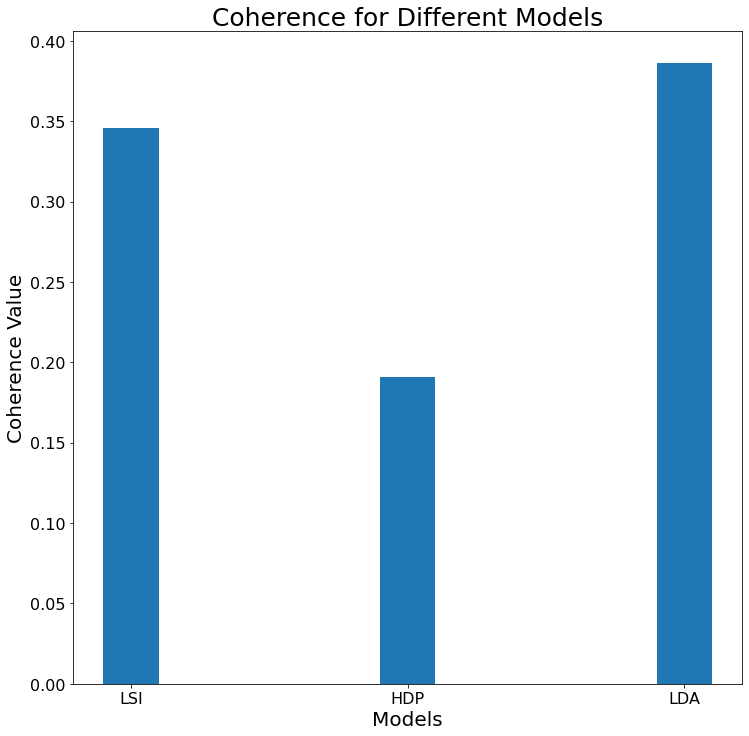

In [63]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 2), (6, 1), (7, 3), (8, 1), (9, 5), (10, 1), (11, 2), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 5), (29, 1)]


In [ ]:
from pprint import pprint
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
t = lda_model.print_topics()
t[1][0]

for i in range(len(t)):
  var = str(t[i][0])
  var2 = str(t[i][1])
  print("topic: " + var )
  print( var2)



topic: 0
0.025*"trump" + 0.012*"president" + 0.005*"saudi" + 0.005*"house" + 0.005*"donald" + 0.004*"administration" + 0.004*"former" + 0.004*"white" + 0.003*"read" + 0.003*"new"
topic: 1
0.034*"trump" + 0.013*"president" + 0.008*"mueller" + 0.006*"house" + 0.005*"manafort" + 0.005*"new" + 0.005*"white" + 0.005*"counsel" + 0.005*"campaign" + 0.005*"special"
topic: 2
0.014*"trump" + 0.009*"president" + 0.009*"senate" + 0.006*"democrats" + 0.006*"gop" + 0.006*"house" + 0.006*"republican" + 0.005*"republicans" + 0.004*"also" + 0.004*"democratic"
topic: 3
0.018*"trump" + 0.016*"president" + 0.007*"white" + 0.005*"new" + 0.005*"house" + 0.004*"read" + 0.003*"officials" + 0.003*"senate" + 0.003*"donald" + 0.003*"acosta"
topic: 4
0.014*"house" + 0.013*"trump" + 0.008*"white" + 0.006*"president" + 0.005*"new" + 0.005*"also" + 0.004*"state" + 0.004*"court" + 0.004*"women" + 0.004*"last"
topic: 5
0.022*"trump" + 0.012*"president" + 0.007*"trade" + 0.007*"house" + 0.004*"tariffs" + 0.004*"white" 

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print(df_dominant_topic.head(10))

   Document_No  ...                                               Text
0            0  ...  [inexpensive, quickly, deleted, tweet, house, ...
1            1  ...  [white, house, monday, worried, stock, market,...
2            2  ...  [rep, devin, nunes, author, newly, declassifie...
3            3  ...  [president, donald, trump, lashed, top, democr...
4            4  ...  [house, intelligence, committee, voted, monday...
5            5  ...  [president, donald, trump, monday, offered, co...
6            6  ...  [day, markets, already, putting, fed, chair, j...
7            7  ...  [jerome, powell, hands, full, become, chairman...
8            8  ...  [senators, introducing, compromise, legislatio...
9            9  ...  [leading, republican, campaign, group, offerin...

[10 rows x 5 columns]


In [ ]:
print('\nPerplexity:', lda_model.log_perplexity(corpus))

from gensim.models import CoherenceModel

coherence_score_lda = CoherenceModel(lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nCoherence Score:', coherence_score)

In [ ]:
#this is for LSI model
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


lsamodel = LsiModel(corpus, num_topics=5, id2word =id2word)  # train model
print(lsamodel.print_topics())

t = lsamodel.print_topics()


for i in range(len(t)):
  var = str(t[i][0])
  var2 = str(t[i][1])
  print("topic: " + var )
  print( var2)

Unused figures and code

In [ ]:
df = pd.read_sql_query("SELECT * FROM articles WHERE (source LIKE '%CNN%') OR (source LIKE '%Fox News%') OR (source LIKE '%NBC%') ", cnx_2018)

ds = pd.DataFrame(df, columns = ['source', 'content'])
ds = ds.sample(n=1000, random_state=1)
print(ds.head())

         source                                            content
9947        CNN  Washington (CNN) Iranian President Hassan Rouh...
1901       CNBC  President Donald Trump reportedly wants to tak...
14153  Fox News  The New Yorker's sketchy report that Supreme C...
10408     MSNBC  # Sons of Korean War Vet receive father's dog ...
17929     MSNBC  Judge rules against Kemp over voters misidenti...


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:

vec = TfidfVectorizer(stop_words="english")
vec.fit(ds.content.values)
features = vec.transform(ds.content.values)

In [ ]:

cls = MiniBatchKMeans(n_clusters=3, random_state=3)
cls.fit(features)

MiniBatchKMeans(n_clusters=3, random_state=3)

In [ ]:
cls.labels_

In [ ]:

# reduce the features to 2D
pca = PCA(n_components=3, random_state=3)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

In [ ]:
ds["source"].replace({'CNN': "0.3", 'Fox News': "1", 'CNBC': "0.7", 'MSNBC': "0.7"}, inplace=True)

pd.unique(ds.source)

array(['0.3', '0.7', '1'], dtype=object)

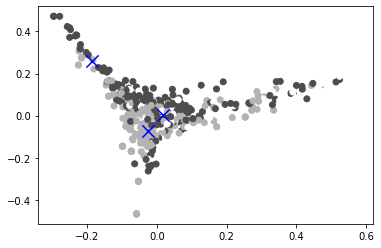

In [ ]:
from sklearn.preprocessing import LabelEncoder
fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
plt.scatter(reduced_features[:,0], reduced_features[:,1] ,c=ds.source, cmap = 'viridis')
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [ ]:
from collections import Counter
NUM_WORDS = 20
long_string = ','.join(list(nbc_2018['content_processed'].values))
words = long_string.split()
cptwords = {}
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'https', 'said', 'us', 'would', 'like','says', 'could', 'two', 'told', 'going', 'one', '*', 'also'])

word_counts = Counter(word for word in words
                      if word not in set(stop_words))
tempFrame = pd.DataFrame(columns = ["x", "y"])

print(f'\nThe {NUM_WORDS} most frequent words are:\n')
for i, (word, count) in enumerate(word_counts.most_common(NUM_WORDS)):
    print('%2s. %4s %s' % (i, count, word))
    tempFrame.loc[len(tempFrame.index)] = [ word, count] 
    


The 20 most frequent words are:

 0. 14013 trump
 1. 7699 president
 2. 5035 house
 3. 3576 new
 4. 3493 white
 5. 3201 donald
 6. 2780 republican
 7. 2592 campaign
 8. 2382 former
 9. 2338 trump's
10. 2240 last
11. 2205 senate
12. 1991 election
13. 1958 news
14. 1942 state
15. 1899 democrats
16. 1893 time
17. 1814 read
18. 1814 trumps
19. 1792 year


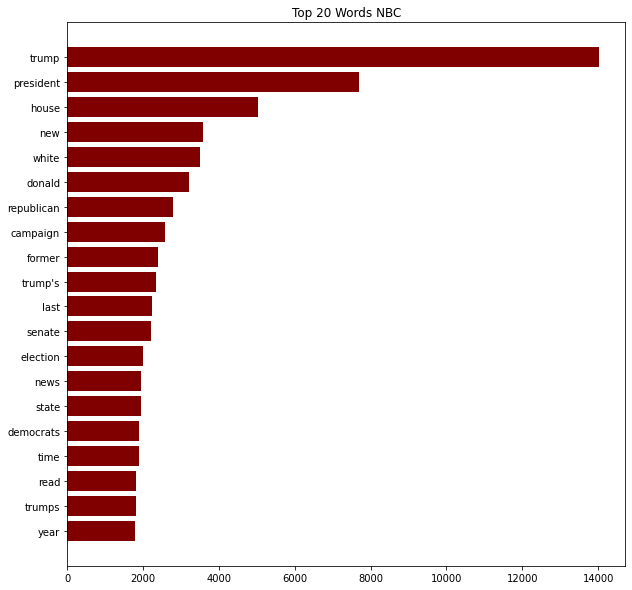

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.barh(tempFrame.x, tempFrame.y, color ='maroon')
plt.title("Top 20 Words NBC")
plt.gca().invert_yaxis()

In [ ]:
from collections import Counter
NUM_WORDS = 20
long_string = ','.join(list(fox_2018['content_processed'].values))
words = long_string.split()
cptwords = {}
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'https', 'said', 'us', 'would', 'like','says', 'could', 'two', 'told', 'going', 'one', '*', 'also'])

word_counts = Counter(word for word in words
                      if word not in set(stop_words))
tempFrame = pd.DataFrame(columns = ["x", "y"])

print(f'\nThe {NUM_WORDS} most frequent words are:\n')
for i, (word, count) in enumerate(word_counts.most_common(NUM_WORDS)):
    print('%2s. %4s %s' % (i, count, word))
    tempFrame.loc[len(tempFrame.index)] = [ word, count] 
    


The 20 most frequent words are:

 0. 12040 trump
 1. 7155 president
 2. 5457 house
 3. 4273 news
 4. 4121 fox
 5. 4109 kavanaugh
 6. 4043 state
 7. 4040 democrats
 8. 3944 senate
 9. 3853 republican
10. 3764 campaign
11. 3697 democratic
12. 3558 new
13. 3442 court
14. 3423 former
15. 3175 people
16. 2995 election
17. 2733 republicans
18. 2713 white
19. 2613 last


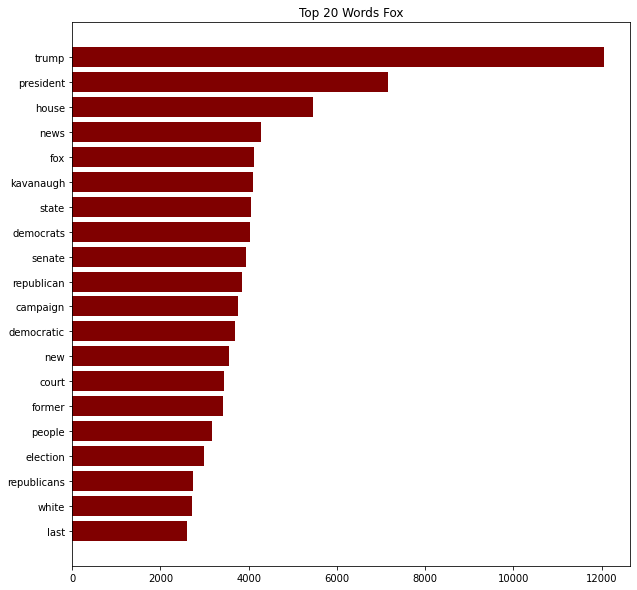

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.barh(tempFrame.x, tempFrame.y, color ='maroon')
plt.title("Top 20 Words Fox")
plt.gca().invert_yaxis()

In [ ]:
from collections import Counter
NUM_WORDS = 20
long_string = ','.join(list(cnn_2018['content_processed'].values))
words = long_string.split()
cptwords = {}
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'https', 'said', 'us', 'would', 'like','says', 'could', 'two', 'told', 'going', 'one', '*', 'also', '--', '"i'])

word_counts = Counter(word for word in words
                      if word not in set(stop_words))
tempFrame = pd.DataFrame(columns = ["x", "y"])

print(f'\nThe {NUM_WORDS} most frequent words are:\n')
for i, (word, count) in enumerate(word_counts.most_common(NUM_WORDS)):
    print('%2s. %4s %s' % (i, count, word))
    tempFrame.loc[len(tempFrame.index)] = [ word, count] 
    


The 20 most frequent words are:

 0. 37970 trump
 1. 19781 president
 2. 15157 house
 3. 10757 white
 4. 9878 trump's
 5. 8232 new
 6. 8175 republican
 7. 7989 people
 8. 7808 campaign
 9. 7670 democrats
10. 7489 cnn
11. 6729 senate
12. 6716 former
13. 6703 last
14. 6667 time
15. 6638 first
16. 6540 state
17. 6314 democratic
18. 6012 election
19. 5766 court


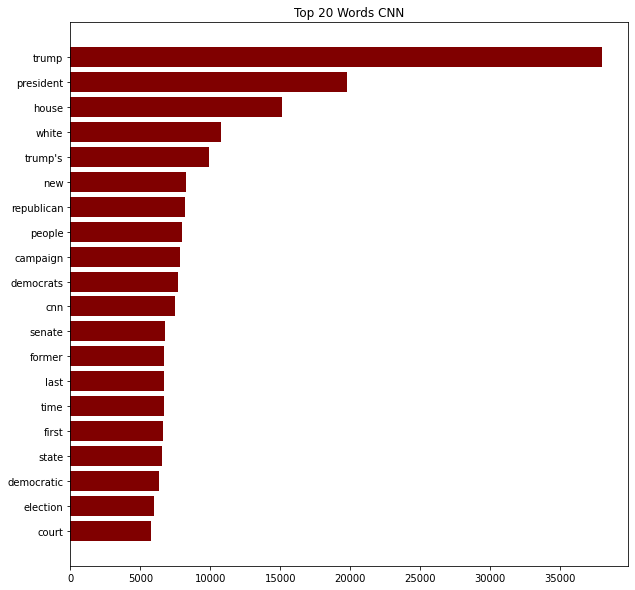

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.barh(tempFrame.x, tempFrame.y, color ='maroon')
plt.title("Top 20 Words CNN")
plt.gca().invert_yaxis()

In [ ]:
import re
cnx = df#just those 3 news sources
#this is only for the content column. propbs should do titles too
#df = df.sample(n=10000, random_state=1)
cnx['content_processed'] = \
cnx['content'].map(lambda x: re.sub('[,\.!?]', '', x))

cnx['content_processed'] = \
cnx['content_processed'].map(lambda x: x.lower())

cnx['content_processed'].head()


0    one inexpensive  and quickly deleted  tweet by...
1    the white house said monday it is worried abou...
2    rep devin nunes is the author of a newly decla...
3    president donald trump lashed out at the top d...
4    the house intelligence committee voted monday ...
Name: content_processed, dtype: object

In [ ]:

from collections import Counter
NUM_WORDS = 20
long_string = ','.join(list(cnx['content_processed'].values))
words = long_string.split()
cptwords = {}
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'https', 'said', 'us', 'would', 'like','says', 'could', 'two', 'told', 'going', 'one', '*', 'also', '--', '"i'])

word_counts = Counter(word for word in words
                      if word not in set(stop_words))
tempFrame = pd.DataFrame(columns = ["x", "y"])

print(f'\nThe {NUM_WORDS} most frequent words are:\n')
for i, (word, count) in enumerate(word_counts.most_common(NUM_WORDS)):
    print('%2s. %4s %s' % (i, count, word))
    tempFrame.loc[len(tempFrame.index)] = [ word, count] 
    


The 20 most frequent words are:

 0. 64023 trump
 1. 34634 president
 2. 25649 house
 3. 16963 white
 4. 15366 new
 5. 14808 republican
 6. 14164 campaign
 7. 13609 democrats
 8. 13267 trump's
 9. 12907 people
10. 12878 senate
11. 12525 state
12. 12521 former
13. 11556 last
14. 11512 democratic
15. 10998 election
16. 10995 time
17. 10923 court
18. 10567 first
19. 10184 republicans


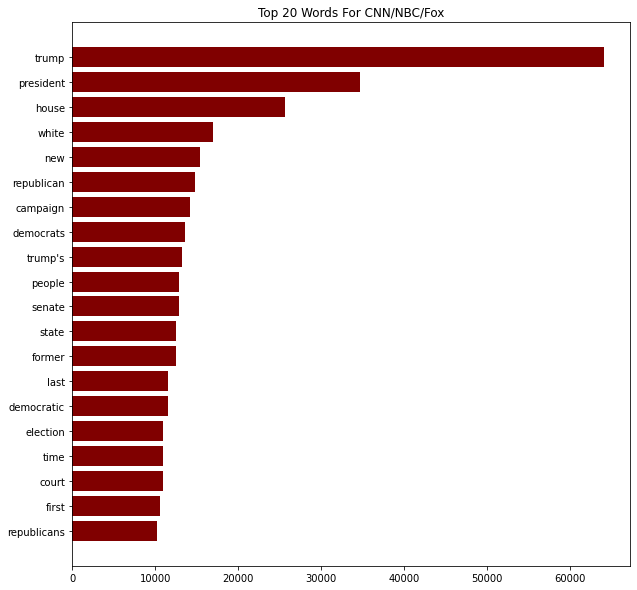

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.barh(tempFrame.x, tempFrame.y, color ='maroon')
plt.title("Top 20 Words For CNN/NBC/Fox")
plt.gca().invert_yaxis()